In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.dummy import DummyClassifier

In [2]:
df = pd.read_csv('../../datasets/model.csv', index_col = [0])

### Explain each variable choice

In [3]:
X = df[['ydstogo', 'run', 'td_prob', 'goal_to_go']]
y = df['4th_down_conversion']

# Confusion Matrices and ROCs of Boosting

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [5]:
ada = AdaBoostClassifier()

In [6]:
ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [7]:
ada.score(X_train, y_train)

0.6342825237297599

In [8]:
ada.score(X_test, y_test)

0.6465661641541038

# Gridsearch for best params

In [9]:
ada = AdaBoostClassifier()
ada_params = {
    'n_estimators': [38, 39, 40, 41, 42],
    'learning_rate': [.08, .09, .1, .11, .12]
}
gs = GridSearchCV(ada, param_grid=ada_params)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.6253489670575098


{'learning_rate': 0.11, 'n_estimators': 41}

In [10]:
gs.score(X_train, y_train)

0.6256281407035176

In [11]:
gs.score(X_test, y_test)

0.6557788944723618

In [12]:
preds = gs.predict(X_test)

In [13]:
confusion_matrix(y_test, preds)  

array([[435, 203],
       [208, 348]])

In [14]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [15]:
# What is the specificity of our test set?

spec = tn / (tn + fp)

# sPecificity = TN / all negatives = TN / (TN + FP)

print(f'Specificity: {round(spec,4)}')

Specificity: 0.6818


In [16]:
# What is the sensitivity of our test set?

sens = tp / (tp + fn)

# seNsitivity = TP / all positives = TP / (TP + FN)

print(f'Sensitivity: {round(sens,4)}')

Sensitivity: 0.6259


In [17]:
# What is the accuracy of our test set?
acc = (tp + tn) / (tp + tn + fp + fn)

print(f'Accuracy: {round(acc,4)}')

Accuracy: 0.6558


In [18]:
# What is the precision of our test set?

prec = tp / (tp + fp)


print(f'Precision: {round(prec,4)}')

Precision: 0.6316


In [19]:
pred_proba = [i[1] for i in gs.predict_proba(X_test)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

In [20]:
pred_df.head()

,true_values,pred_probs
2724,1.0,0.442203
44543,1.0,0.518062
257237,1.0,0.491294
300830,0.0,0.524013
376804,1.0,0.524013


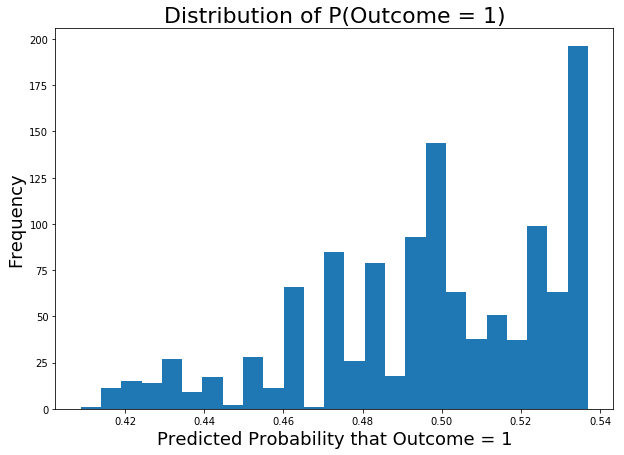

In [21]:
# Create figure.
plt.figure(figsize = (10,7))

# Create histogram of observations.
plt.hist(pred_df['pred_probs'], bins=25)

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)
plt.savefig('../../images/boosting/distribution_1.png');

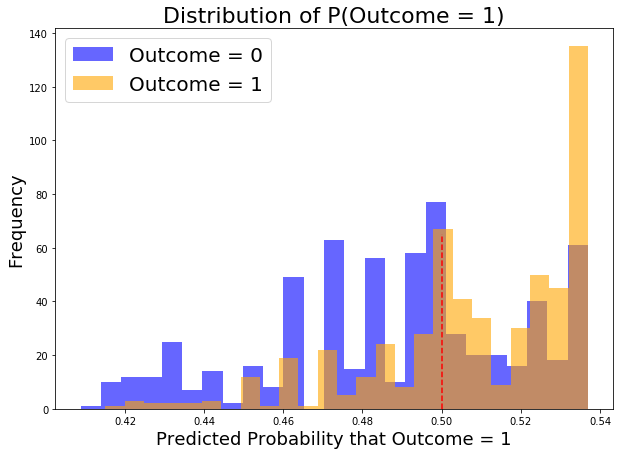

In [22]:

# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Outcome = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = 1')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
           ymin = 0,
           ymax = 65,
           color='r',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20)
plt.savefig('../../images/boosting/distribution_2.png');

In [23]:
roc_auc_score(pred_df['true_values'], pred_df['pred_probs'])

0.6974512866196072

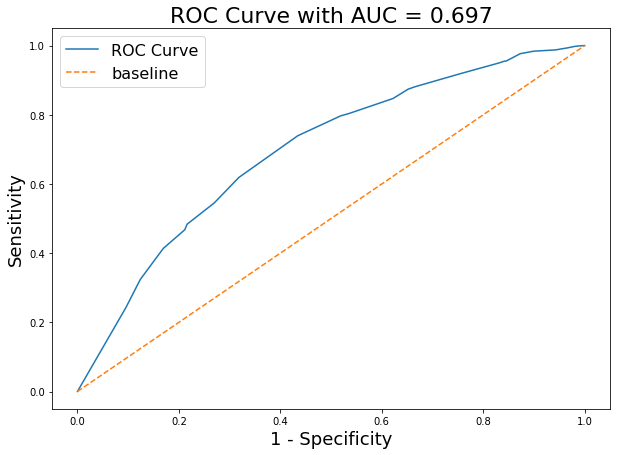

In [24]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    
# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16)
plt.savefig('../../images/boosting/roc.png');